## Titanic Analysis

### Import

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, count, mean
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Initialize a Spark session

In [34]:
spark = SparkSession.builder \
    .appName("Titanic") \
    .getOrCreate()

### Load the Titanic training and testing datasets

In [35]:
train_data = spark.read.csv("data/train.csv", header=True, inferSchema=True)
test_data = spark.read.csv("data/test.csv", header=True, inferSchema=True)

### Display the first 10 rows of the dataset for a better overview

In [36]:
train_data.show(10)
test_data.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

### Calculate survival rates

In [37]:
rate_women = train_data.filter(col("Sex") == 'female').agg(mean("Survived")).first()[0] * 100
print(f"% of women who survived: {rate_women:.2f}%")
rate_men = train_data.filter(col("Sex") == 'male').agg(mean("Survived")).first()[0] * 100
print(f"% of men who survived: {rate_men:.2f}%")

% of women who survived: 74.20%
% of men who survived: 18.89%


### 1. Handling Missing Values

In [38]:
# For Age: Impute with median
median_age = train_data.approxQuantile("Age", [0.5], 0)[0]
train_data = train_data.fillna({"Age": median_age})
test_data = test_data.fillna({"Age": median_age})

# For Embarked: Impute with the most frequent value (mode)
most_frequent_embarked = train_data.groupBy("Embarked").agg(count("Embarked").alias("count")).orderBy(col("count").desc()).first()[0]
train_data = train_data.fillna({"Embarked": most_frequent_embarked})

# For Fare: Impute with median for test data if it's missing
median_fare = test_data.approxQuantile("Fare", [0.5], 0)[0]
test_data = test_data.fillna({"Fare": median_fare})

### 2. Feature Engineering

In [39]:
train_data = train_data.withColumn("FamilySize", col("SibSp") + col("Parch") + lit(1))
test_data = test_data.withColumn("FamilySize", col("SibSp") + col("Parch") + lit(1))

train_data = train_data.withColumn("IsAlone", when(col("FamilySize") == 1, 1).otherwise(0))
test_data = test_data.withColumn("IsAlone", when(col("FamilySize") == 1, 1).otherwise(0))

# Extract Title from Name
train_data = train_data.withColumn("Title", when(col("Name").contains("Mrs."), "Mrs")
                                     .when(col("Name").contains("Mr."), "Mr")
                                     .when(col("Name").contains("Miss."), "Miss")
                                     .otherwise("Other"))
test_data = test_data.withColumn("Title", when(col("Name").contains("Mrs."), "Mrs")
                                     .when(col("Name").contains("Mr."), "Mr")
                                     .when(col("Name").contains("Miss."), "Miss")
                                     .otherwise("Other"))

### 3. Encoding Categorical Variables

In [40]:
indexer_sex = StringIndexer(inputCol="Sex", outputCol="Sex_Index")
indexer_embarked = StringIndexer(inputCol="Embarked", outputCol="Embarked_Index")
indexer_title = StringIndexer(inputCol="Title", outputCol="Title_Index")

encoder_embarked = OneHotEncoder(inputCols=["Embarked_Index"], outputCols=["Embarked_OHE"])
encoder_title = OneHotEncoder(inputCols=["Title_Index"], outputCols=["Title_OHE"])

# Create a pipeline for transformations
pipeline = Pipeline(stages=[indexer_sex, indexer_embarked, indexer_title, encoder_embarked, encoder_title])
train_data = pipeline.fit(train_data).transform(train_data)
test_data = pipeline.fit(test_data).transform(test_data)

### 4. Dropping Unnecessary Columns

In [41]:
train_data = train_data.drop("Name", "Ticket", "Cabin", "SibSp", "Parch", "FamilySize", "Title", "Embarked", "Sex")
test_data = test_data.drop("Name", "Ticket", "Cabin", "SibSp", "Parch", "FamilySize", "Title", "Embarked", "Sex")


### 5. Preparing Features and Target

Validation accuracy: 78.21%
Confusion matrix was successfully saved!
Classification report was successfully saved!


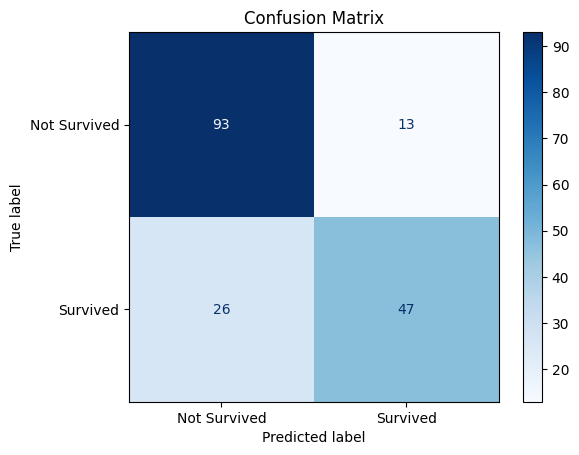

Your submission was successfully saved!


In [42]:
# Prepare Features and Target
y = train_data.select("Survived").toPandas()
X = train_data.toPandas().drop("Survived", axis=1)

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize the XGBoost model
model = xgb.XGBClassifier(n_estimators=100, random_state=1)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the validation data
val_predictions = model.predict(X_val)

# Calculate the accuracy of the model on the validation set
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

# Calculate and save the confusion matrix
cm = confusion_matrix(y_val, val_predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df.to_csv('confusion_matrix.csv', index=True)
print("Confusion matrix was successfully saved!")

# Generate and save the classification report
report = classification_report(y_val, val_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report.csv', index=True)
print("Classification report was successfully saved!")

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Survived", "Survived"])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Make predictions on the test set
X_test = test_data.toPandas()
X_test = X_test.apply(pd.to_numeric, errors='coerce')
test_predictions = model.predict(X_test)

# Create the output dataframe for submission
output = pd.DataFrame({'PassengerId': test_data.toPandas()['PassengerId'], 'Survived': test_predictions})

# Save predictions to CSV file
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

# Stop the Spark session
spark.stop()